# Comparing a LSTM, GRU, and RNN network for regressing prices of SPY US Equity

In [51]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import time
from sklearn.model_selection import GridSearchCV

spy = pd.read_csv('newdata/SPY.csv')
spy.head()

,ticker,SPY US Equity,SPY US Equity.1,SPY US Equity.2,SPY US Equity.3,SPY US Equity.4,Close Tomorrow
0,field,PX_LAST,PX_OPEN,MOV_AVG_200D,MOV_AVG_5D,MOV_AVG_50D,NaN
1,date,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,145.4375,148.25,134.9281,146.3906,140.2524,139.75
3,2000-01-04,139.75,143.5313,134.9771,145.1031,140.4455,140.0
4,2000-01-05,140.0,139.9375,135.0462,143.7406,140.6568,137.75


## Data Preparation

In [52]:
dataDate = spy.loc[:, 'ticker'].values
dataLastPrice = spy.loc[:, 'SPY US Equity'].values

# pop junk out of here
dataDate = dataDate[2:]
dataLP = dataLastPrice[2:].astype(float)

In [53]:
class Transformations():
    def __init__(self):
        self.mu = None
        self.sd = None

    def normalize(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        return (x-self.mu)/self.sd

    def inverseNormalize(self, x):
        return x*self.sd + self.mu

transformer = Transformations()
normLP = transformer.normalize(dataLP)

In [54]:
strideLength = 20

def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, strideLength)
    data_y = prepare_data_y(normalized_data_close_price, strideLength)

    # split dataset

    split_index_test_val = int(data_y.shape[0]*0.6)
    split_index_val_test = int(data_y.shape[0]*0.6) + int(data_y.shape[0]*0.2)
    data_x_train = data_x[:split_index_train_val]
    data_x_val = data_x[split_index_train_val:split_index_val_test]
    data_x_test = data_x[split_index_val_test:]

    data_y_train = data_y[:split_index_train_val]
    data_y_val = data_y[split_index_train_val:split_index_val_test]
    data_y_test = data_y[split_index_val_test:]

    return split_index_train_val, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_test, data_y_test, data_x_unseen = prepare_data(normLP)

Next, we need to create our training, validation and testing sets:

In [55]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
dataset_test = TimeSeriesDataset(data_x_test, data_y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Testing data shape", dataset_test.x.shape, dataset_test.y.shape)

Train data shape (3451, 20, 1) (3451,)
Validation data shape (1150, 20, 1) (1150,)
Testing data shape (1152, 20, 1) (1152,)


# The LSTM Model

In [56]:
class LSTMModel(nn.Module):
    
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]


input_size = 1 # sine we are only using 1 feature, close price
num_lstm_layers = 10
lstm_size =  32
dropout = 0.2
lstmModel = LSTMModel(input_size=input_size, hidden_layer_size=lstm_size, num_layers=num_lstm_layers, output_size=1, dropout=dropout)
lstmModel = lstmModel.to('cpu')

# LSTM Hyper Parameter Search

In [84]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
from functools import partial


def trainLSTM(config, checkpoint_dir=None, data_dir=None):
    lstmModel = LSTMModel(input_size=1, hidden_layer_size=config['hidden_size'], num_layers=config['num_layers'], output_size=1, dropout=config['dropout'])
    # hyper parameters
    batch_size = config['batch_size']

    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

    learning_rate = config['lr']
    mseLoss = nn.MSELoss()

    optimizer = optim.Adam(lstmModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

    num_epochs = config['epochs']

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        lstmModel.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    overallLSTMTrainLoss = []
    overallLSTMValLoss = []
    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []
        lstmModel.train()
        for idx, (x_batch, y_batch) in enumerate(train_dataloader):

            optimizer.zero_grad()

            out = lstmModel(x_batch)

            loss = mseLoss(out.contiguous(), y_batch.contiguous())

            loss.backward()
            optimizer.step()

            batchsize = x_batch.shape[0]
            train_losses.append(loss.detach().item() / batchsize)
            
        overallLSTMTrainLoss.append(sum(train_losses))

        lstmModel.eval()
        for idx, (x_batch, y_batch) in enumerate(val_dataloader):
            
            out = lstmModel(x_batch)
            
            loss = mseLoss(out.contiguous(), y_batch.contiguous())
            batchsize = x_batch.shape[0]
            val_losses.append(loss.detach().item() / batchsize)

        overallLSTMValLoss.append(sum(val_losses))


        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((lstmModel.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(sum(val_losses)))

        #print('Epoch[{}/{}] Train MSE: {:.6f}, Train RMSE: {:.6f}, Val MSE: {:.6f}, Val RMSE: {:.6f}'
        #        .format(epoch+1, num_epochs, sum(train_losses), math.sqrt(sum(train_losses)), sum(val_losses), math.sqrt(sum(val_losses))))

    


data_dir= os.path.abspath('./lstmTrainData')

config = {
    "batch_size": tune.choice([8, 16]),
    "num_layers": tune.choice([2, 6, 8]),
    "hidden_size": tune.choice([8, 16, 32, 64]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
    "epochs": tune.choice([25, 50, 100]),
    "dropout": tune.loguniform(0.1, 0.35)
}

reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "training_iteration"])

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=1,
        reduction_factor=2)

num_samples = 10


t0 = time.time()
result = tune.run(
    partial(trainLSTM, data_dir=data_dir),
    resources_per_trial={"cpu": 8},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))

lstmTrainTime = time.time() - t0
print('50 hyperparameter tuning pairs tested and completed in ', lstmTrainTime, 'seconds')

== Status ==
Current time: 2022-12-15 13:41:47 (running for 00:00:00.18)
Memory usage on this node: 10.6/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 8.0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainLSTM_2022-12-15_13-41-47
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+
| Trial name            | status   | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |
|-----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------|
| trainLSTM_212e6_00000 | RUNNING  | 127.0.0.1:13857 |            8 |  0.286422 |     

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainLSTM_212e6_00000,2022-12-15_13-47-17,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,50,0.316096,127.0.0.1,13857,True,329.326,6.60998,329.326,1671130037,0,,50,212e6_00000,0.00208879
trainLSTM_212e6_00001,2022-12-15_13-47-23,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,1,48.1553,127.0.0.1,13857,True,5.46956,5.46956,5.46956,1671130043,0,,1,212e6_00001,0.00208879
trainLSTM_212e6_00002,2022-12-15_13-47-24,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,2,2.57116,127.0.0.1,13857,True,1.41964,0.69956,1.41964,1671130044,0,,2,212e6_00002,0.00208879
trainLSTM_212e6_00003,2022-12-15_13-47-27,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,1,13.4658,127.0.0.1,13857,True,2.53005,2.53005,2.53005,1671130047,0,,1,212e6_00003,0.00208879
trainLSTM_212e6_00004,2022-12-15_13-49-00,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,16,1.28908,127.0.0.1,13857,True,93.4598,5.75274,93.4598,1671130140,0,,16,212e6_00004,0.00208879
trainLSTM_212e6_00005,2022-12-15_13-49-06,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,1,159.141,127.0.0.1,13857,True,5.5938,5.5938,5.5938,1671130146,0,,1,212e6_00005,0.00208879
trainLSTM_212e6_00006,2022-12-15_13-49-14,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,2,3.56712,127.0.0.1,13857,True,8.09552,4.1141,8.09552,1671130154,0,,2,212e6_00006,0.00208879
trainLSTM_212e6_00007,2022-12-15_13-49-15,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,1,5.4162,127.0.0.1,13857,True,1.50516,1.50516,1.50516,1671130155,0,,1,212e6_00007,0.00208879
trainLSTM_212e6_00008,2022-12-15_13-50-48,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,16,2.61803,127.0.0.1,13857,True,92.7475,5.84071,92.7475,1671130248,0,,16,212e6_00008,0.00208879
trainLSTM_212e6_00009,2022-12-15_13-52-03,True,,6cd04223140d49dc922544dc7a3e2110,wireless-10-104-165-134.umd.edu,100,0.205698,127.0.0.1,13857,True,75.0835,0.76608,75.0835,1671130323,0,,100,212e6_00009,0.00208879


== Status ==
Current time: 2022-12-15 13:42:00 (running for 00:00:12.93)
Memory usage on this node: 10.4/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -2.326399130281061
Resources requested: 8.0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainLSTM_2022-12-15_13-41-47
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+--------+----------------------+
| Trial name            | status   | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |   loss |   training_iteration |
|-----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+--------+

2022-12-15 13:52:03,938	INFO tune.py:762 -- Total run time: 616.80 seconds (616.67 seconds for the tuning loop).


== Status ==
Current time: 2022-12-15 13:52:03 (running for 00:10:16.68)
Memory usage on this node: 10.7/16.0 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: -0.3666896549319582 | Iter 32.000: -0.5860043371399765 | Iter 16.000: -1.2182177786792938 | Iter 8.000: -0.4823922231063036 | Iter 4.000: -1.310268198765698 | Iter 2.000: -2.096552255214192 | Iter 1.000: -3.2691716429932667
Resources requested: 0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainLSTM_2022-12-15_13-41-47
Number of trials: 10/10 (10 TERMINATED)
+-----------------------+------------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+------------+----------------------+
| Trial name            | status     | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |       loss |   training_iteration |
|-----------------------+------------+----------------

### Train the LSTM Model using optimal hyperparams

In [86]:

# Using optimal hyperparameters from hyperparam search
batch_size = best_trial.config['batch_size']

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

learning_rate = best_trial.config['lr']
mseLoss = nn.MSELoss()

lstmModel = LSTMModel(input_size=1, hidden_layer_size=best_trial.config['hidden_size'], num_layers=best_trial.config['num_layers'],
    output_size=1, dropout=best_trial.config['dropout'])

optimizer = optim.Adam(lstmModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

num_epochs = best_trial.config['epochs']



overallLSTMTrainLoss = []
overallLSTMValLoss = []
t0 = time.time()
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    lstmModel.train()
    for idx, (x_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        out = lstmModel(x_batch)

        loss = mseLoss(out.contiguous(), y_batch.contiguous())

        loss.backward()
        optimizer.step()

        batchsize = x_batch.shape[0]
        train_losses.append(loss.detach().item() / batchsize)
        
    overallLSTMTrainLoss.append(sum(train_losses))

    lstmModel.eval()
    for idx, (x_batch, y_batch) in enumerate(val_dataloader):
        
        out = lstmModel(x_batch)
        
        loss = mseLoss(out.contiguous(), y_batch.contiguous())
        batchsize = x_batch.shape[0]
        val_losses.append(loss.detach().item() / batchsize)

    overallLSTMValLoss.append(sum(val_losses))

    print('Epoch[{}/{}] Train MSE: {:.6f}, Train RMSE: {:.6f}, Val MSE: {:.6f}, Val RMSE: {:.6f}'
            .format(epoch+1, num_epochs, sum(train_losses), math.sqrt(sum(train_losses)), sum(val_losses), math.sqrt(sum(val_losses))))
lstmTrainTime = time.time() - t0

print('Training completed in ', lstmTrainTime, 'seconds')

Epoch[1/100] Train MSE: 0.664654, Train RMSE: 0.815263, Val MSE: 0.408873, Val RMSE: 0.639432
Epoch[2/100] Train MSE: 0.058623, Train RMSE: 0.242122, Val MSE: 0.303506, Val RMSE: 0.550914
Epoch[3/100] Train MSE: 0.041841, Train RMSE: 0.204552, Val MSE: 0.308687, Val RMSE: 0.555596
Epoch[4/100] Train MSE: 0.033059, Train RMSE: 0.181822, Val MSE: 0.338028, Val RMSE: 0.581402
Epoch[5/100] Train MSE: 0.027017, Train RMSE: 0.164370, Val MSE: 0.330935, Val RMSE: 0.575270
Epoch[6/100] Train MSE: 0.023845, Train RMSE: 0.154419, Val MSE: 0.342507, Val RMSE: 0.585241
Epoch[7/100] Train MSE: 0.020568, Train RMSE: 0.143415, Val MSE: 0.316549, Val RMSE: 0.562627
Epoch[8/100] Train MSE: 0.017821, Train RMSE: 0.133496, Val MSE: 0.287733, Val RMSE: 0.536408
Epoch[9/100] Train MSE: 0.015026, Train RMSE: 0.122579, Val MSE: 0.266780, Val RMSE: 0.516508
Epoch[10/100] Train MSE: 0.013619, Train RMSE: 0.116701, Val MSE: 0.251892, Val RMSE: 0.501888
Epoch[11/100] Train MSE: 0.012479, Train RMSE: 0.111708, Va

### Plot Loss curves for LSTM Training

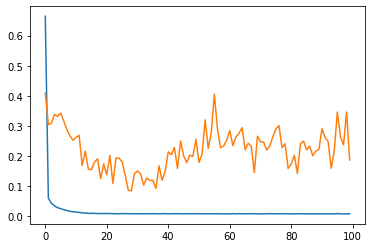

In [87]:
plt.plot(overallLSTMTrainLoss)
plt.plot(overallLSTMValLoss)

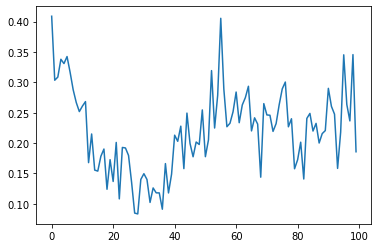

In [88]:
plt.plot(overallLSTMValLoss)

# RNN Model

In [89]:

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # RNN layers
        self.rnn = nn.RNN(
            input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_size)
        
        return self.fc(out)[:, -1]

# RNN Hyper Parameter Search

In [90]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
from functools import partial


def trainRNN(config, checkpoint_dir=None, data_dir=None):
    rnnModel = RNNModel(input_size=1, hidden_layer_size=config['hidden_size'], num_layers=config['num_layers'], output_size=1, dropout=config['dropout'])
    # hyper parameters
    batch_size = config['batch_size']

    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

    learning_rate = config['lr']
    mseLoss = nn.MSELoss()

    optimizer = optim.Adam(rnnModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

    num_epochs = config['epochs']

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        rnnModel.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    overallRNNTrainLoss = []
    overallRNNValLoss = []
    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []
        rnnModel.train()
        for idx, (x_batch, y_batch) in enumerate(train_dataloader):

            optimizer.zero_grad()

            out = rnnModel(x_batch)

            loss = mseLoss(out.contiguous(), y_batch.contiguous())

            loss.backward()
            optimizer.step()

            batchsize = x_batch.shape[0]
            train_losses.append(loss.detach().item() / batchsize)
            
        overallRNNTrainLoss.append(sum(train_losses))

        rnnModel.eval()
        for idx, (x_batch, y_batch) in enumerate(val_dataloader):
            
            out = rnnModel(x_batch)
            
            loss = mseLoss(out.contiguous(), y_batch.contiguous())
            batchsize = x_batch.shape[0]
            val_losses.append(loss.detach().item() / batchsize)

        overallRNNValLoss.append(sum(val_losses))


        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((rnnModel.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(sum(val_losses)))

        #print('Epoch[{}/{}] Train MSE: {:.6f}, Train RMSE: {:.6f}, Val MSE: {:.6f}, Val RMSE: {:.6f}'
        #        .format(epoch+1, num_epochs, sum(train_losses), math.sqrt(sum(train_losses)), sum(val_losses), math.sqrt(sum(val_losses))))

    


data_dir= os.path.abspath('./rnnTrainData')

config = {
    "batch_size": tune.choice([8, 16]),
    "num_layers": tune.choice([2, 6, 8]),
    "hidden_size": tune.choice([8, 16, 32, 64]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
    "epochs": tune.choice([25, 50, 100]),
    "dropout": tune.loguniform(0.1, 0.35)
}

reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "training_iteration"])

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=1,
        reduction_factor=2)

num_samples = 10

t0 = time.time()
result = tune.run(
    partial(trainRNN, data_dir=data_dir),
    resources_per_trial={"cpu": 8},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trialRNN = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trialRNN.config))
print("Best trial final validation loss: {}".format(
    best_trialRNN.last_result["loss"]))

rnnTrainTime = time.time() - t0
print('50 hyperparameter tuning pairs tested and completed in ', rnnTrainTime, 'seconds')

== Status ==
Current time: 2022-12-15 13:57:46 (running for 00:00:00.18)
Memory usage on this node: 10.8/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 8.0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainRNN_2022-12-15_13-57-46
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+
| Trial name           | status   | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |
|----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------|
| trainRNN_5ce7c_00000 | RUNNING  | 127.0.0.1:14403 |            4 |  0.153326 |       25 

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainRNN_5ce7c_00000,2022-12-15_13-58-16,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,25,47.8274,127.0.0.1,14403,True,28.8923,1.15883,28.8923,1671130696,0,,25,5ce7c_00000,0.00219417
trainRNN_5ce7c_00001,2022-12-15_13-58-32,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,25,12.2736,127.0.0.1,14403,True,15.7369,0.605101,15.7369,1671130712,0,,25,5ce7c_00001,0.00219417
trainRNN_5ce7c_00002,2022-12-15_13-58-35,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,1,54.7814,127.0.0.1,14403,True,3.34588,3.34588,3.34588,1671130715,0,,1,5ce7c_00002,0.00219417
trainRNN_5ce7c_00003,2022-12-15_13-58-55,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,25,0.873592,127.0.0.1,14403,True,20.1003,0.815301,20.1003,1671130735,0,,25,5ce7c_00003,0.00219417
trainRNN_5ce7c_00004,2022-12-15_14-00-11,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,50,6.71785,127.0.0.1,14403,True,75.6957,1.5092,75.6957,1671130811,0,,50,5ce7c_00004,0.00219417
trainRNN_5ce7c_00005,2022-12-15_14-00-20,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,25,0.959479,127.0.0.1,14403,True,8.53021,0.337851,8.53021,1671130820,0,,25,5ce7c_00005,0.00219417
trainRNN_5ce7c_00006,2022-12-15_14-00-23,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,2,17.5513,127.0.0.1,14403,True,3.47448,1.74743,3.47448,1671130823,0,,2,5ce7c_00006,0.00219417
trainRNN_5ce7c_00007,2022-12-15_14-00-25,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,2,20.1292,127.0.0.1,14403,True,2.13121,1.06723,2.13121,1671130825,0,,2,5ce7c_00007,0.00219417
trainRNN_5ce7c_00008,2022-12-15_14-00-43,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,25,0.0141883,127.0.0.1,14403,True,17.6666,0.688352,17.6666,1671130843,0,,25,5ce7c_00008,0.00219417
trainRNN_5ce7c_00009,2022-12-15_14-01-51,True,,5a80ec375c9c43688288e9d09095d829,wireless-10-104-165-134.umd.edu,100,3.04871,127.0.0.1,14403,True,68.1047,0.684344,68.1047,1671130911,0,,100,5ce7c_00009,0.00219417


== Status ==
Current time: 2022-12-15 13:57:52 (running for 00:00:06.07)
Memory usage on this node: 10.9/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -80.71544378995895 | Iter 2.000: -62.419288501143456 | Iter 1.000: -53.92755692452192
Resources requested: 8.0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainRNN_2022-12-15_13-57-46
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+---------+----------------------+
| Trial name           | status   | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |    loss |   training_iteration |
|----------------------+----------+-----------------+--------------+-----------+----------+---------------+-----------

2022-12-15 14:01:51,748	INFO tune.py:762 -- Total run time: 245.42 seconds (245.29 seconds for the tuning loop).


== Status ==
Current time: 2022-12-15 14:01:51 (running for 00:04:05.29)
Memory usage on this node: 10.3/16.0 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: -2.5966044041172913 | Iter 32.000: -3.855175051353096 | Iter 16.000: -1.133734267271523 | Iter 8.000: -1.4406156671632613 | Iter 4.000: -1.540495449943202 | Iter 2.000: -5.386641790159047 | Iter 1.000: -8.879311186649527
Resources requested: 0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainRNN_2022-12-15_13-57-46
Number of trials: 10/10 (10 TERMINATED)
+----------------------+------------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+------------+----------------------+
| Trial name           | status     | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |       loss |   training_iteration |
|----------------------+------------+-----------------+-----

### Train the RNN Model on Optimal Hyper Parameters

In [92]:
# hyper parameters
batch_size = best_trialRNN.config['batch_size']

train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

rnnModel = RNNModel(input_size=1, hidden_layer_size=best_trialRNN.config['hidden_size'], num_layers=best_trialRNN.config['num_layers'], 
                    output_size=1, dropout=best_trialRNN.config['dropout'])

learning_rate = best_trialRNN.config['lr']
msemseLoss = nn.MSELoss()
optimizer = optim.Adam(rnnModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

num_epochs = best_trialRNN.config['epochs']


overallRNNTrainLoss = []
overallRNNValLoss = []
t0 = time.time()
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    rnnModel.train()
    for idx, (x_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        out = rnnModel(x_batch)

        loss = mseLoss(out.contiguous(), y_batch.contiguous())

        loss.backward()
        optimizer.step()

        batchsize = x_batch.shape[0]
        train_losses.append(loss.detach().item() / batchsize)
        
    overallRNNTrainLoss.append(sum(train_losses))

    rnnModel.eval()
    for idx, (x_batch, y_batch) in enumerate(val_dataloader):
        
        out = rnnModel(x_batch)
        
        loss = mseLoss(out.contiguous(), y_batch.contiguous())
        batchsize = x_batch.shape[0]
        val_losses.append(loss.detach().item() / batchsize)

    overallRNNValLoss.append(sum(val_losses))


    print('Epoch[{}/{}] Train MSE: {:.6f}, Train RMSE: {:.6f}, Val MSE: {:.6f}, Val RMSE: {:.6f}'
            .format(epoch+1, num_epochs, sum(train_losses), math.sqrt(sum(train_losses)), sum(val_losses), math.sqrt(sum(val_losses))))

rnnTrainTime = time.time() - t0
print('RNN finished training in', rnnTrainTime, 'seconds')

Epoch[1/25] Train MSE: 1.772789, Train RMSE: 1.331461, Val MSE: 0.104426, Val RMSE: 0.323150
Epoch[2/25] Train MSE: 0.106790, Train RMSE: 0.326788, Val MSE: 0.060259, Val RMSE: 0.245477
Epoch[3/25] Train MSE: 0.074887, Train RMSE: 0.273655, Val MSE: 0.020187, Val RMSE: 0.142080
Epoch[4/25] Train MSE: 0.059262, Train RMSE: 0.243437, Val MSE: 0.054451, Val RMSE: 0.233348
Epoch[5/25] Train MSE: 0.052990, Train RMSE: 0.230195, Val MSE: 0.023116, Val RMSE: 0.152040
Epoch[6/25] Train MSE: 0.046518, Train RMSE: 0.215680, Val MSE: 0.063924, Val RMSE: 0.252831
Epoch[7/25] Train MSE: 0.043904, Train RMSE: 0.209533, Val MSE: 0.019913, Val RMSE: 0.141114
Epoch[8/25] Train MSE: 0.042173, Train RMSE: 0.205361, Val MSE: 0.017851, Val RMSE: 0.133606
Epoch[9/25] Train MSE: 0.035512, Train RMSE: 0.188447, Val MSE: 0.049776, Val RMSE: 0.223106
Epoch[10/25] Train MSE: 0.036914, Train RMSE: 0.192131, Val MSE: 0.021578, Val RMSE: 0.146895
Epoch[11/25] Train MSE: 0.034421, Train RMSE: 0.185529, Val MSE: 0.03

### Plot the training and validation loss for RNN Training

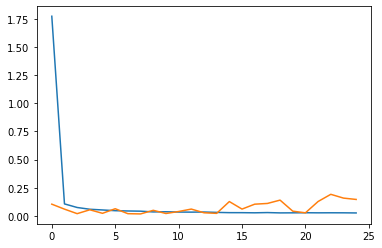

In [93]:
plt.plot(overallRNNTrainLoss)
plt.plot(overallRNNValLoss)

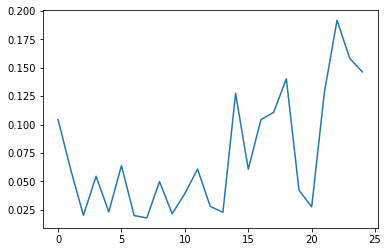

In [94]:
plt.plot(overallRNNValLoss)

# GRU Model

In [95]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size

        # GRU layers
        self.gru = nn.GRU(
            input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        batchsize = x.shape[0]
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h_n= self.gru(x, h0.detach())
        ##x = h_n.permute(1, 0, 2).reshape(batchsize, -1)
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_size)
        out = self.fc(out)[:, -1]#out

        return out


# GRU Hyper Parameter Search

In [96]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
from functools import partial


def trainGRU(config, checkpoint_dir=None, data_dir=None):
    gruModel = GRUModel(input_size=1, hidden_layer_size=config['hidden_size'], num_layers=config['num_layers'], output_size=1, dropout=config['dropout'])
    # hyper parameters
    batch_size = config['batch_size']

    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

    learning_rate = config['lr']
    mseLoss = nn.MSELoss()

    optimizer = optim.Adam(gruModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

    num_epochs = config['epochs']

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        gruModel.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    overallGRUTrainLoss = []
    overallGRUValLoss = []
    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []
        gruModel.train()
        for idx, (x_batch, y_batch) in enumerate(train_dataloader):

            optimizer.zero_grad()

            out = gruModel(x_batch)

            loss = mseLoss(out.contiguous(), y_batch.contiguous())

            loss.backward()
            optimizer.step()

            batchsize = x_batch.shape[0]
            train_losses.append(loss.detach().item() / batchsize)
            
        overallGRUTrainLoss.append(sum(train_losses))

        gruModel.eval()
        for idx, (x_batch, y_batch) in enumerate(val_dataloader):
            
            out = gruModel(x_batch)
            
            loss = mseLoss(out.contiguous(), y_batch.contiguous())
            batchsize = x_batch.shape[0]
            val_losses.append(loss.detach().item() / batchsize)

        overallGRUValLoss.append(sum(val_losses))


        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((gruModel.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(sum(val_losses)))

        #print('Epoch[{}/{}] Train MSE: {:.6f}, Train RMSE: {:.6f}, Val MSE: {:.6f}, Val RMSE: {:.6f}'
        #        .format(epoch+1, num_epochs, sum(train_losses), math.sqrt(sum(train_losses)), sum(val_losses), math.sqrt(sum(val_losses))))

    


data_dir= os.path.abspath('./gruTrainData')

config = {
    "batch_size": tune.choice([8, 16]),
    "num_layers": tune.choice([2, 6, 8]),
    "hidden_size": tune.choice([8, 16, 32, 64]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
    "epochs": tune.choice([25, 50, 100]),
    "dropout": tune.loguniform(0.1, 0.35)
}

reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "training_iteration"])

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=100,
        grace_period=1,
        reduction_factor=2)

num_samples = 10


t0 = time.time()
result = tune.run(
    partial(trainGRU, data_dir=data_dir),
    resources_per_trial={"cpu": 8},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trialGRU = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trialGRU.config))
print("Best trial final validation loss: {}".format(
    best_trialGRU.last_result["loss"]))

gruTrainTime = time.time() - t0
print('50 hyperparameter tuning pairs tested and completed in ', gruTrainTime, 'seconds')

== Status ==
Current time: 2022-12-15 14:04:43 (running for 00:00:00.18)
Memory usage on this node: 10.5/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 8.0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainGRU_2022-12-15_14-04-42
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+
| Trial name           | status   | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |
|----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------|
| trainGRU_5532f_00000 | RUNNING  | 127.0.0.1:14623 |           16 |  0.137894 |       50 

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainGRU_5532f_00000,2022-12-15_14-05-22,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,50,0.306715,127.0.0.1,14623,True,38.2679,0.751516,38.2679,1671131122,0,,50,5532f_00000,0.00220609
trainGRU_5532f_00001,2022-12-15_14-05-23,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,1,3.37267,127.0.0.1,14623,True,0.75775,0.75775,0.75775,1671131123,0,,1,5532f_00001,0.00220609
trainGRU_5532f_00002,2022-12-15_14-05-28,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,2,0.41909,127.0.0.1,14623,True,4.81763,2.39933,4.81763,1671131128,0,,2,5532f_00002,0.00220609
trainGRU_5532f_00003,2022-12-15_14-05-30,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,1,4.64763,127.0.0.1,14623,True,2.24083,2.24083,2.24083,1671131130,0,,1,5532f_00003,0.00220609
trainGRU_5532f_00004,2022-12-15_14-05-35,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,4,0.260141,127.0.0.1,14623,True,5.61802,1.38612,5.61802,1671131135,0,,4,5532f_00004,0.00220609
trainGRU_5532f_00005,2022-12-15_14-05-43,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,8,0.21453,127.0.0.1,14623,True,7.44687,0.92823,7.44687,1671131143,0,,8,5532f_00005,0.00220609
trainGRU_5532f_00006,2022-12-15_14-05-46,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,1,4.6168,127.0.0.1,14623,True,3.03469,3.03469,3.03469,1671131146,0,,1,5532f_00006,0.00220609
trainGRU_5532f_00007,2022-12-15_14-06-07,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,1,54.9194,127.0.0.1,14623,True,20.7478,20.7478,20.7478,1671131167,0,,1,5532f_00007,0.00220609
trainGRU_5532f_00008,2022-12-15_14-06-13,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,1,1.97586,127.0.0.1,14623,True,6.47896,6.47896,6.47896,1671131173,0,,1,5532f_00008,0.00220609
trainGRU_5532f_00009,2022-12-15_14-06-19,True,,a53ac07350fc44a5a1dbdd9d1460ce0f,wireless-10-104-165-134.umd.edu,4,0.111245,127.0.0.1,14623,True,5.97498,1.50729,5.97498,1671131179,0,,4,5532f_00009,0.00220609


== Status ==
Current time: 2022-12-15 14:04:48 (running for 00:00:05.45)
Memory usage on this node: 10.8/16.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -0.07298571021029991 | Iter 2.000: -0.13548512865340204 | Iter 1.000: -0.14056412835738488
Resources requested: 8.0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainGRU_2022-12-15_14-04-42
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+----------------------+----------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+-----------+----------------------+
| Trial name           | status   | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |      loss |   training_iteration |
|----------------------+----------+-----------------+--------------+-----------+----------+---------------+--

2022-12-15 14:06:19,837	INFO tune.py:762 -- Total run time: 96.94 seconds (96.81 seconds for the tuning loop).


== Status ==
Current time: 2022-12-15 14:06:19 (running for 00:01:36.81)
Memory usage on this node: 10.7/16.0 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 32.000: -0.08916814076032356 | Iter 16.000: -0.012899071573753775 | Iter 8.000: -0.11707876790738478 | Iter 4.000: -0.09211559189030336 | Iter 2.000: -0.13548512865340204 | Iter 1.000: -1.1253510486980456
Resources requested: 0/10 CPUs, 0/0 GPUs, 0.0/5.86 GiB heap, 0.0/2.0 GiB objects
Result logdir: /Users/jakebaldwin/ray_results/trainGRU_2022-12-15_14-04-42
Number of trials: 10/10 (10 TERMINATED)
+----------------------+------------+-----------------+--------------+-----------+----------+---------------+-------------+--------------+-----------+----------------------+
| Trial name           | status     | loc             |   batch_size |   dropout |   epochs |   hidden_size |          lr |   num_layers |      loss |   training_iteration |
|----------------------+------------+-----------------+-----------

### Train GRU on Optimal Hyper Parameters

In [97]:
# hyper parameters
batch_size = best_trialGRU.config['batch_size']


train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

gruModel = GRUModel(input_size=1, hidden_layer_size=best_trialGRU.config['hidden_size'], num_layers=best_trialGRU.config['num_layers'], 
                    output_size=1, dropout=best_trialGRU.config['dropout'])

learning_rate = best_trialGRU.config['lr']
mseLoss = nn.MSELoss()
optimizer = optim.Adam(gruModel.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

num_epochs = best_trialGRU.config['epochs']


overallGRUTrainLoss = []
overallGRUValLoss = []
t0 = time.time()
for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    gruModel.train()
    for idx, (x_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        out = gruModel(x_batch)
    
        loss = mseLoss(out.contiguous(), y_batch.contiguous())

        loss.backward()
        optimizer.step()

        batchsize = x_batch.shape[0]
        train_losses.append(loss.detach().item() / batchsize)
        
    overallGRUTrainLoss.append(sum(train_losses))
    #break
    gruModel.eval()
    for idx, (x_batch, y_batch) in enumerate(val_dataloader):
        
        out = gruModel(x_batch)
        loss = mseLoss(out.contiguous(), y_batch.contiguous())
        batchsize = x_batch.shape[0]
        val_losses.append(loss.detach().item() / batchsize)


    overallGRUValLoss.append(sum(val_losses))

    print('Epoch[{}/{}] Train MSE: {:.6f}, Train RMSE: {:.6f}, Val MSE: {:.6f}, Val RMSE: {:.6f}'
            .format(epoch+1, num_epochs, sum(train_losses), math.sqrt(sum(train_losses)), sum(val_losses), math.sqrt(sum(val_losses))))

gruTrainTime = time.time() - t0
print('GRU finished training in', gruTrainTime, 'seconds')

Epoch[1/50] Train MSE: 0.628286, Train RMSE: 0.792645, Val MSE: 0.172484, Val RMSE: 0.415312
Epoch[2/50] Train MSE: 0.051227, Train RMSE: 0.226334, Val MSE: 0.109221, Val RMSE: 0.330486
Epoch[3/50] Train MSE: 0.040032, Train RMSE: 0.200081, Val MSE: 0.115862, Val RMSE: 0.340385
Epoch[4/50] Train MSE: 0.033895, Train RMSE: 0.184106, Val MSE: 0.167680, Val RMSE: 0.409488
Epoch[5/50] Train MSE: 0.031712, Train RMSE: 0.178080, Val MSE: 0.151802, Val RMSE: 0.389618
Epoch[6/50] Train MSE: 0.031243, Train RMSE: 0.176757, Val MSE: 0.119351, Val RMSE: 0.345472
Epoch[7/50] Train MSE: 0.028989, Train RMSE: 0.170262, Val MSE: 0.087646, Val RMSE: 0.296050
Epoch[8/50] Train MSE: 0.027432, Train RMSE: 0.165625, Val MSE: 0.087924, Val RMSE: 0.296520
Epoch[9/50] Train MSE: 0.025148, Train RMSE: 0.158583, Val MSE: 0.062744, Val RMSE: 0.250487
Epoch[10/50] Train MSE: 0.024223, Train RMSE: 0.155638, Val MSE: 0.235957, Val RMSE: 0.485754
Epoch[11/50] Train MSE: 0.023158, Train RMSE: 0.152178, Val MSE: 0.09

### Plotting the Validation and Training Losses for GRU Training

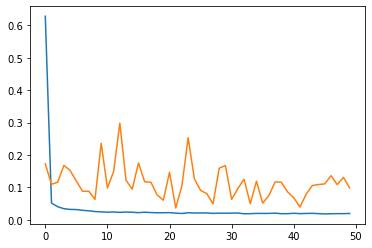

In [98]:
plt.plot(overallGRUTrainLoss)
plt.plot(overallGRUValLoss)

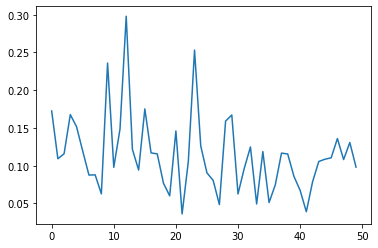

In [99]:
plt.plot(overallGRUValLoss)

# Comparision of these models *graphically*

In [201]:
def plotsForModel(model, modelType, batch_size):

    import warnings
    warnings.filterwarnings("ignore")
    num_data_points = len(data_x_train) + len(data_x_val)

    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
    xticks_interval =  400
    color_actual = "#001f3f"
    color_train = "#3D9970"
    color_val = "#0074D9"
    color_pred_train= "#3D9970"
    color_pred_val = "#0074D9"
    color_pred_test = "#FF4136"


    model.eval()

    # predict on the training data, to see how well the model managed to learn and memorize

    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        out = model(x)
        out = out.cpu().detach().numpy()
        out = out.squeeze()

        predicted_train = np.concatenate((predicted_train, out))

    # predict on the validation data, to see how the model does
    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        out = model(x)

        out = out.cpu().detach().numpy()
        out = out.squeeze()
        predicted_val = np.concatenate((predicted_val, out))


    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)
    to_plot_data_y_train_pred[0:split_index] = transformer.inverseNormalize(predicted_train)
    to_plot_data_y_val_pred[split_index:] = transformer.inverseNormalize(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(dataDate[:num_data_points], dataLP[:num_data_points], label="Actual prices", color=color_actual)
    plt.plot(dataDate[:num_data_points], to_plot_data_y_train_pred, label="Predicted prices (train)", color=color_pred_train)
    plt.plot(dataDate[:num_data_points], to_plot_data_y_val_pred, label="Predicted prices (validation)", color=color_pred_val)
    plt.title("Compare predicted prices to actual prices for " + modelType + ' model')
    xticks = [dataDate[i] if ((i%xticks_interval==0 and (num_data_points-i) > xticks_interval) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = transformer.inverseNormalize(data_y_val)
    to_plot_predicted_val = transformer.inverseNormalize(predicted_val)
    to_plot_data_date = dataDate[split_index:num_data_points]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=color_actual)
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=color_pred_val)
    plt.title("Zoom in to examine predicted price on validation data portion for " + modelType + ' model')
    xticks = [to_plot_data_date[i] if ((i%int(xticks_interval/5)==0 and (len(to_plot_data_date)-i) > xticks_interval/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

## LSTM On Data:

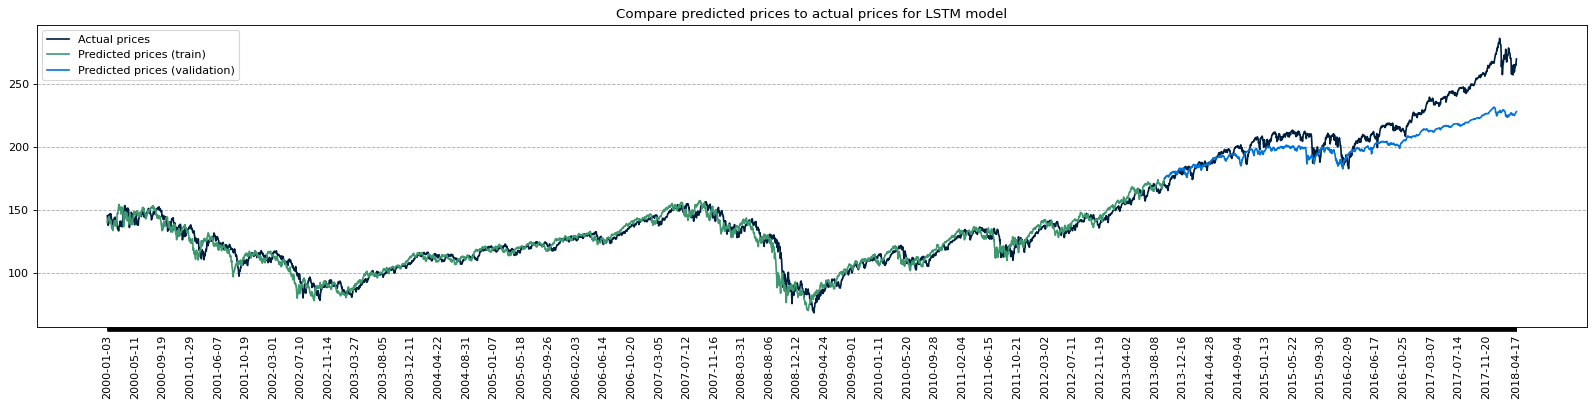

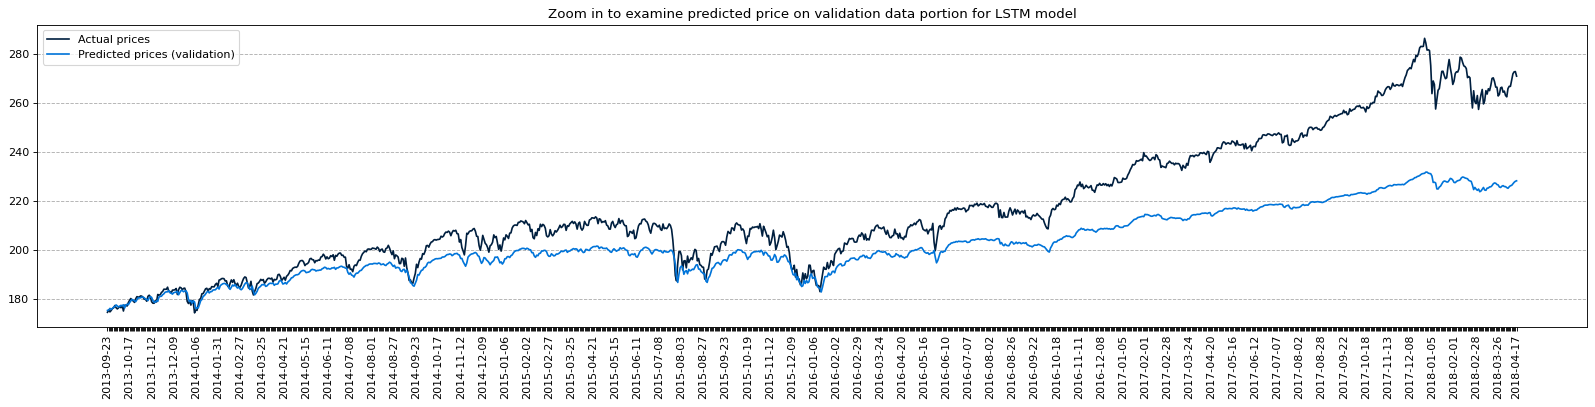

In [103]:
plotsForModel(lstmModel, 'LSTM', best_trial.config['batch_size'])

## RNN On Data:

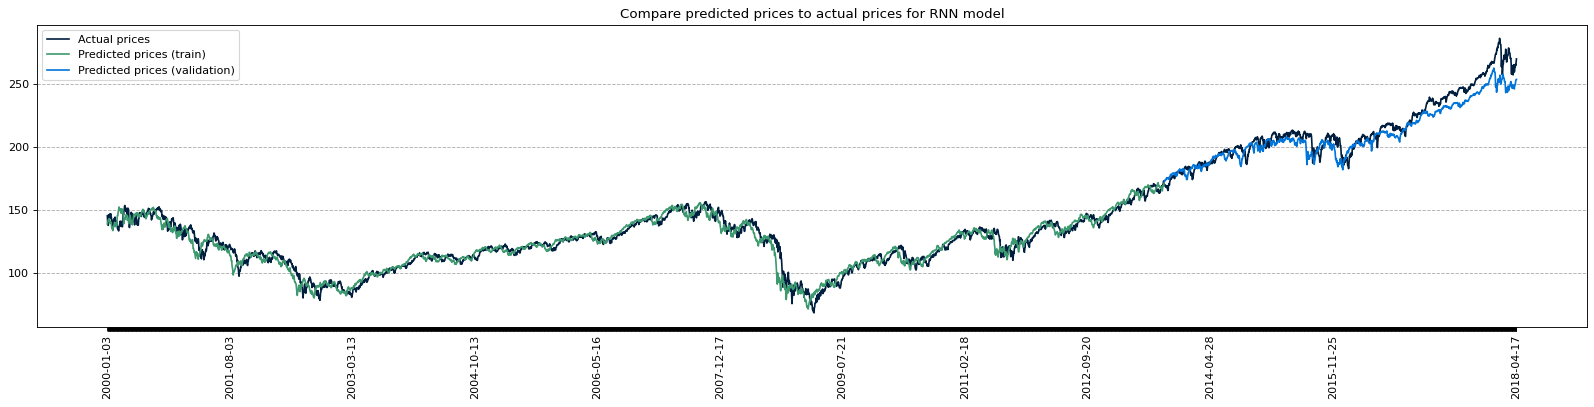

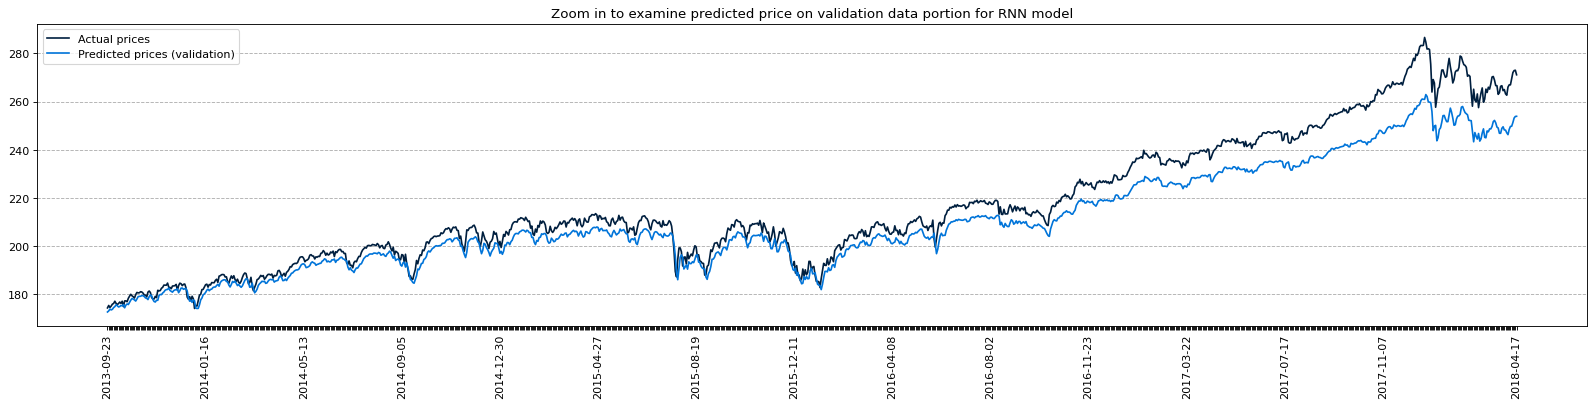

In [202]:
plotsForModel(rnnModel, 'RNN', best_trialRNN.config['batch_size'])

## GRU On Data:

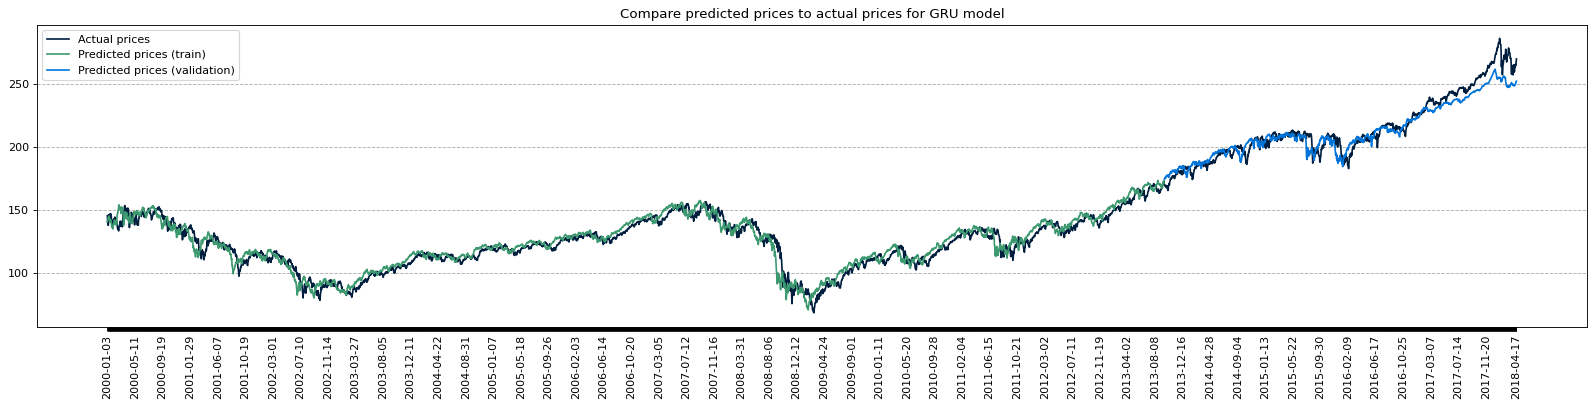

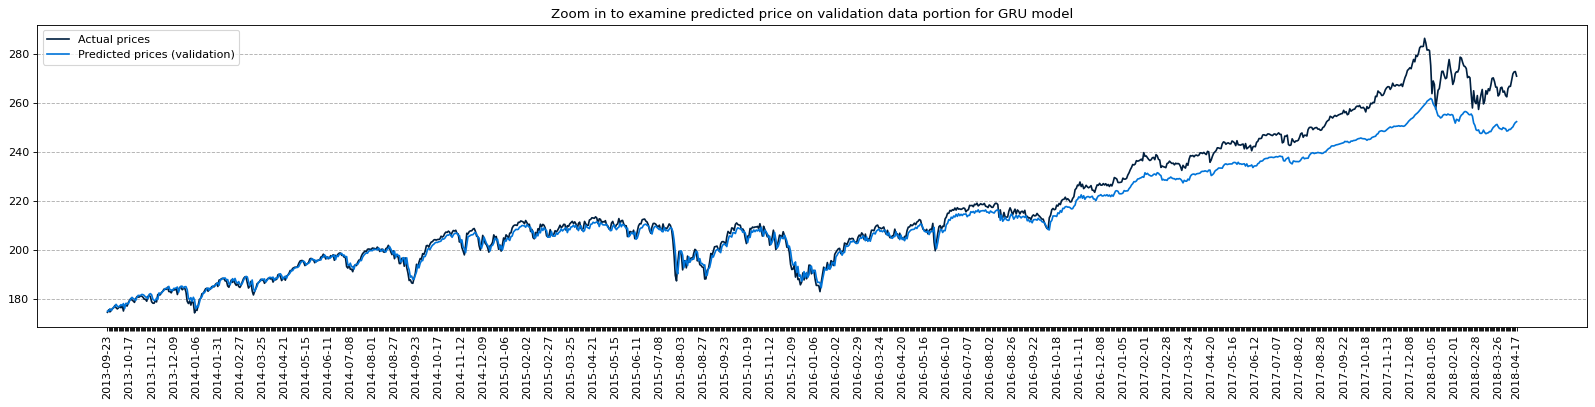

In [105]:
with torch.no_grad():
    plotsForModel(gruModel, 'GRU', best_trialGRU.config['batch_size'])

# Test Set Evaluation

### MSE, RMSE, R^2 Values

In [161]:
from torchmetrics import R2Score
import math
target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
mseLoss = nn.MSELoss()
r2 = R2Score()


with torch.no_grad():
    # LSTM ANALYSIS
    lstmModel.eval()

    test_dataloader = DataLoader(dataset_test, batch_size=best_trial.config['batch_size'], shuffle=False)

    preds = torch.tensor([])
    ys = torch.tensor([])
    lstmMSEs = []
    for idx, (x_batch, y_batch) in enumerate(test_dataloader):

        pred = lstmModel(x_batch)

        loss = mseLoss(pred.contiguous(), y_batch.contiguous())
        lstmMSEs.append(loss.detach().item())
        
        preds = torch.cat((preds, pred), 0)
        ys = torch.cat((ys, y_batch), 0)

        lstmR2s.append(r2Score)

    lstmMSE = sum(lstmMSEs)/len(lstmMSEs)
    lstmRMSE = math.sqrt(lstmMSE)
    lstmR2 = r2(preds, ys).item()


    # RNN ANALYSIS
    rnnModel.eval()

    test_dataloader = DataLoader(dataset_test, batch_size=best_trialRNN.config['batch_size'], shuffle=False)

    preds = torch.tensor([])
    ys = torch.tensor([])
    rnnMSEs = []
    for idx, (x_batch, y_batch) in enumerate(test_dataloader):

        pred = rnnModel(x_batch)

        loss = mseLoss(pred.contiguous(), y_batch.contiguous())
        rnnMSEs.append(loss.detach().item())

        preds = torch.cat((preds, pred), 0)
        ys = torch.cat((ys, y_batch), 0)

    rnnMSE = sum(rnnMSEs)/len(rnnMSEs)
    rnnRMSE = math.sqrt(rnnMSE)
    rnnR2 = r2(preds, ys).item()


    # GRU ANALYSIS
    gruModel.eval()

    test_dataloader = DataLoader(dataset_test, batch_size=best_trialGRU.config['batch_size'], shuffle=False)

    preds = torch.tensor([])
    ys = torch.tensor([])
    gruMSEs = []
    for idx, (x_batch, y_batch) in enumerate(test_dataloader):

        pred = gruModel(x_batch)

        loss = mseLoss(pred.contiguous(), y_batch.contiguous())
        gruMSEs.append(loss.detach().item())

        preds = torch.cat((preds, pred), 0)
        ys = torch.cat((ys, y_batch), 0)

    gruMSE = sum(gruMSEs)/len(gruMSEs)
    gruRMSE = math.sqrt(gruMSE)
    gruR2 = r2(ys, preds).item()

errorDF = pd.DataFrame([['LSTM', lstmMSE, lstmRMSE, lstmR2], ['RNN', rnnMSE, rnnRMSE, rnnR2], ['GRU', gruMSE, gruRMSE, gruR2]], columns=['Model', 'MSE', 'RMSE', 'R2'])
errorDF

,Model,MSE,RMSE,R2
0,LSTM,1.829684,1.352658,-2.861469
1,RNN,0.397027,0.630101,0.162092
2,GRU,0.550551,0.741991,-6.502058


### Visual Prediction Accuracy

In [197]:
def plotTest(model, modelType, batch_size):
    
    import warnings
    warnings.filterwarnings("ignore")
    num_data_points = len(dataset_test)
    filler = len(dataset_train) + len(dataset_val) + 20


    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
    xticks_interval =  100
    color_actual = "#001f3f"
    color_test = "#FF4136"

    model.eval()

    # predict on the testing data, to see how well the model managed to learn and memorize

    predicted_test = np.array([])

    for idx, (x, y) in enumerate(test_dataloader):
        out = model(x)
        out = out.cpu().detach().numpy()
        out = out.squeeze()

        predicted_test = np.concatenate((predicted_test, out))

    to_plot_data_y_test_pred = np.zeros(num_data_points)
    to_plot_data_y_test_pred[0:split_index] = transformer.inverseNormalize(predicted_test)

    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(dataDate[filler:], dataLP[filler:], label="Actual prices", color=color_actual)
    plt.plot(dataDate[filler:], to_plot_data_y_test_pred, label="Predicted prices (test)", color=color_test)
    plt.title("Compare predicted prices to actual prices for " + modelType + ' model')
    xticks = [dataDate[i] if ((i%xticks_interval==0) or i==filler + num_data_points + 19) else None for i in range(filler, filler + num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

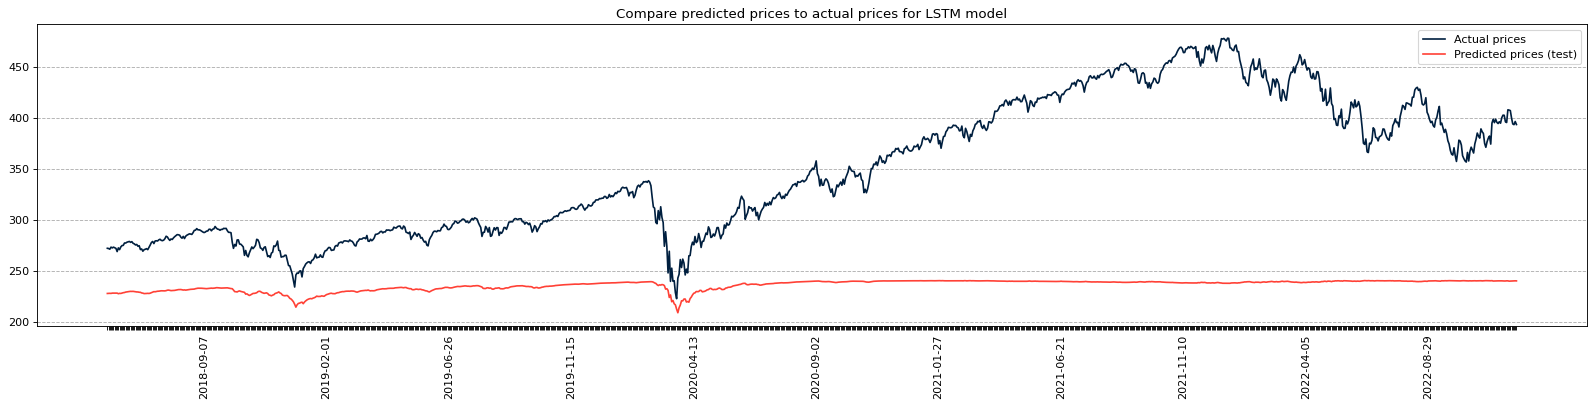

In [198]:
plotTest(lstmModel, 'LSTM', best_trial.config['batch_size'])

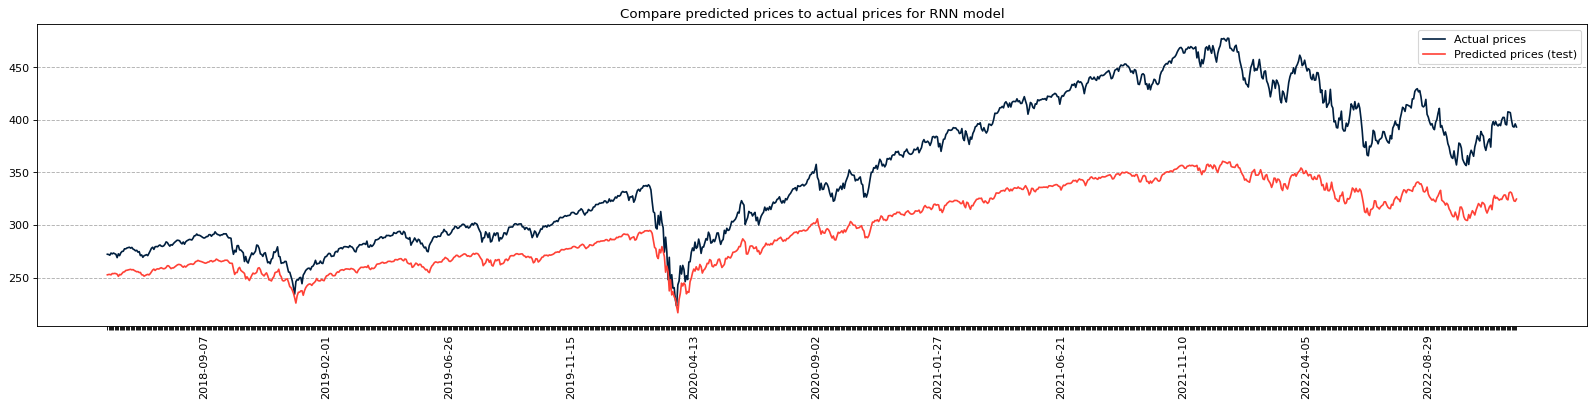

In [199]:
plotTest(rnnModel, 'RNN', best_trialRNN.config['batch_size'])

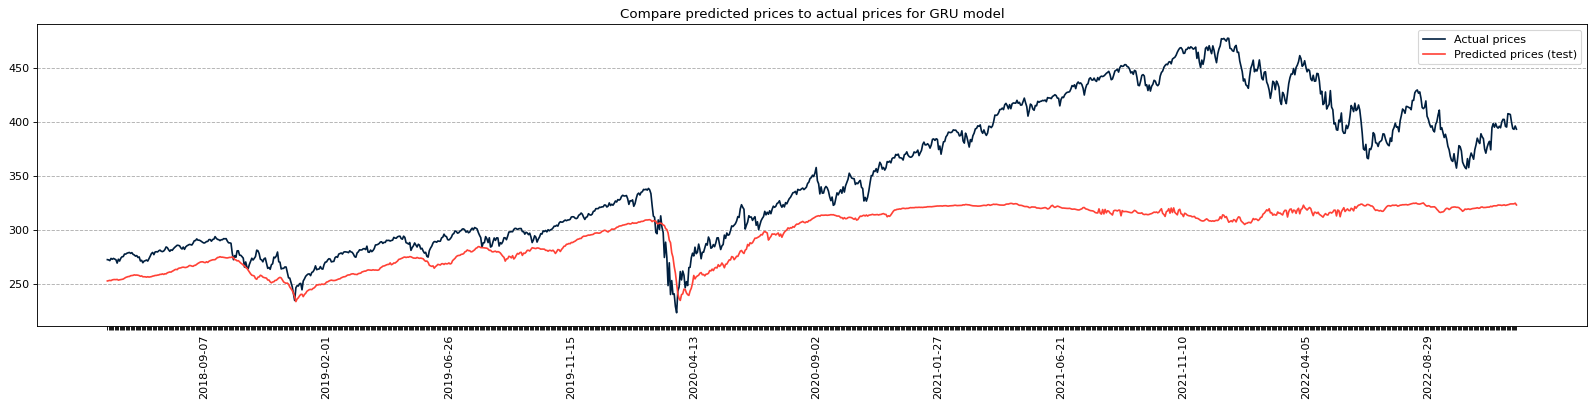

In [200]:
plotTest(gruModel, 'GRU', best_trialGRU.config['batch_size'])